Mini Project 3 for Rosemary Dabbs
======

# Introduction

A survey of 12 questions was given to 1353 people and the responses were recorded. For miniproject 3, I will be looking at how certain explanatory variables affect the priority ranking of my assigned response variable from question 5 of the survey which asks "How important were the following factors when choosing that package for your project?" with the following options for ranking:
* Resolve reported problems quickly
* Helpful discussion on stack exchange
* Number of forks on GitHub
* Reputation of the package's authors
* Package's historic reputation
* Visible growth in popularity
* Familiarity with related packages
* Backlog / number of unresolved issues
* Computing performances
* Number developers of your project
* Scale / size of your project
* Number of stars on GitHub
* Number of watchers on GitHub

These options were ranked by Not a Priority, Low Priority, Medium Priority, High Priority, and Essential
The response varible I was assigned was reputation of the package's authors. Based on this assignment, I will propose a hypothesis and create a model to investigate my predictions. 

# Hypothesis
I hypothesize that the priority ranking for the package's author reputation is going to be affected by the following explanatory variables:
* level of developer experience at the time of your commit
* the purpose of the project: for personal work and/or research use
* And responding "I saw a recommendation for the package" to the following question "which of the following is the closest to why you chose the that package?"

### Explanation of how needed measures are calculated from the provided data
The survey data provided needs to be subsetting to be able to model my response variable. All variables from page five except my assigned response varibale will be extracted. Additionally cleaning will be done to make the model more accurate. 

## First Let's Add Our Survey Data to a Data Frame and Interpret Basic Summary

In [32]:
# Additional Libraries Used:
library(ggplot2) # library for making pretty plots
library(dplyr) # library that provides tools for working with data frames specifically
library(rpart)

In [2]:
# Set global options
# options() will print ALL available options
# Digits controls the number of sig figs when printing numeric values
options(digits=2)

In [3]:
# Read .csv file and assign to data frame called "data"
# Uses the arrow (<-) creates a global variable
# header=TRUE indicates there is a header row in file
data <- read.csv(file="TechSurvey - Survey.csv",header=TRUE,sep=",")

# convert date to unix second
# c combines items into a list or vector
for (i in c("Start", "End")){
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
}
for (i in 0:12){
    vnam = paste(c("PG",i,"Submit"), collapse="")
    data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}

# calculate differences in time    
for (i in 12:0){
    pv = paste(c("PG",i-1,"Submit"), collapse="");
    if (i==0) 
        pv="Start";
    vnam = paste(c("PG",i,"Submit"), collapse="");
    data[,vnam] = data[,vnam] -data[,pv];
}

In [4]:
# Summary of variables
summary(data)

     Device    Completed       Start               End               PG0Dis   
        :  2   0    :  2   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  1   FALSE:546   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :955   TRUE :805   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :376               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 44  
 Tablet : 16               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  3               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                           NA's   :2          NA's   :548        NA's   :73   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 102   Median :    9  
 Mean   : 249   Mean   :  299  
 3rd Qu.: 428   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :73     NA's   :199    
                                       PG1PsnUse  
 For personal work and/or research use      :727  
          

### Interpret  basic summaries

In [5]:
# get numeric fields only for correlation
sel = c()
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);


cor(data[,sel],method="spearman",use="pairwise.complete.obs"); #OK for any: uses ranks

,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1Submit,PG2Submit,PG3Submit,PG4Dtr0_6,PG4Psv7_8,...,PG5_12Order,PG5_13Order,PG5Submit,PG6Submit,PG7Submit,PG8Submit,PG9Submit,PG10Submit,PG11Submit,PG12Submit
Start,1.0000,0.9952,-0.0417,-0.11507,0.1350,0.1156,0.0791,0.0384,0.01210,0.00371,...,-0.0369,0.0598,0.08512,0.0054,0.0776,0.0441,0.04101,0.047,7.9e-02,0.0746
End,0.9952,1.0000,-0.0415,-0.09879,0.1142,0.1550,0.0791,0.0511,-0.05185,-0.04576,...,-0.0359,0.0661,0.09088,0.0051,0.0759,0.0435,0.04071,0.052,7.9e-02,0.0772
PG0Dis,-0.0417,-0.0415,1.0000,0.87220,0.0153,0.0065,0.0041,0.0567,0.16368,0.02668,...,0.0151,0.0384,0.00601,0.0277,0.0097,0.0354,0.00995,-0.029,-4.5e-02,0.0546
PG0Shown,-0.1151,-0.0988,0.8722,1.00000,0.0360,0.0205,0.0023,0.0497,0.08226,0.00036,...,0.0074,0.0407,-0.00888,0.0401,0.0121,0.0264,0.00056,-0.045,-7.1e-02,0.0436
PG0Submit,0.1350,0.1142,0.0153,0.03596,1.0000,0.1088,0.1037,0.1273,-0.00802,-0.03763,...,-0.0161,-0.0280,0.17671,0.1518,0.1365,0.1258,0.17579,0.225,1.1e-01,0.1096
PG1Submit,0.1156,0.1550,0.0065,0.02047,0.1088,1.0000,0.1452,0.2688,-0.06852,0.05661,...,0.0512,-0.0651,0.24670,0.2414,0.1133,0.1069,0.10895,0.170,7.4e-02,0.1137
PG2Submit,0.0791,0.0791,0.0041,0.00235,0.1037,0.1452,1.0000,0.2045,0.00146,0.00897,...,0.0210,-0.0047,0.21851,0.2696,0.1245,0.1567,0.20127,0.099,1.1e-01,0.1073
PG3Submit,0.0384,0.0511,0.0567,0.04968,0.1273,0.2688,0.2045,1.0000,0.00865,0.04424,...,0.0464,-0.0222,0.26048,0.2706,0.1316,0.1822,0.27450,0.161,1.4e-01,0.1642
PG4Dtr0_6,0.0121,-0.0518,0.1637,0.08226,-0.0080,-0.0685,0.0015,0.0087,1.00000,NA,...,0.1774,-0.1289,-0.05214,-0.1618,0.1560,0.0695,-0.07292,0.044,8.4e-04,-0.0272
PG4Psv7_8,0.0037,-0.0458,0.0267,0.00036,-0.0376,0.0566,0.0090,0.0442,NA,1.00000,...,-0.0008,-0.0218,0.08974,-0.0146,-0.0363,0.0526,0.05977,0.069,-4.9e-02,-0.0217


## Basic Correlation Analysis:
The above summary shows the correlations between the numeric variables of our dataset. The Spearman Rank-Order Correlation Coefficient has values between -1 and +1. The closer the coefficient is to +1 the more associated the two variables are and the closest the coefficient is to -1, the more negatively associated the variables are. If the coefficient is 0, there is little to no association between ranks of variables. The correlations at eactly 1 or -1 are too correlated(are the same value) and should not be included in the analysis. Looking of the table of coefficients above, at a quick glance, many of the coefficients are very close to one which would indicate that the variables are very mildly associated.

Let's Filter Out Some of the Extraneous Data:
====

### Transformation and Cleaning of Survey Data
Data was filtered based on:
* Whether the survey was completed
* Whether the suvey was taken on a PC, Phone, or Tablet

In [6]:
# Filter function will find rows/columns where conditions are TRUE and drop any NAs
filtered_data = filter(data, Device == "PC"| Device == "Phone"| Device == "Tablet",)
filtered_data = filter(filtered_data, Completed == "TRUE")

In [7]:
# Number of rows filtered out of data
num_of_rows_before = dim(data)[1]
num_of_rows_after = dim(filtered_data)[1]
print(paste("There were", num_of_rows_before, "rows before filtering and", num_of_rows_after,"after."))

[1] "There were 1353 rows before filtering and 805 after."


Now Let's Answer the Simple Questions to Get to Know the Data Better:
=====

### Time to take entire survey?

In [8]:
# Calculate max and mean submit time
survey_time = filtered_data$End - filtered_data$Start
min_time = min(survey_time) / 60 # convert to minutes
max_time = max(survey_time) / 3600 # convert to hours
mean_time = mean(survey_time) / 60 # convert to minutes
print(paste("The min survey time was", min_time, "minutes"))
print(paste("The max survey time was", round(max_time), "hours"))
print(paste("The mean survey time was roughly", round(mean_time), 'minutes'))

[1] "The min survey time was 0.85 minutes"
[1] "The max survey time was 24 hours"
[1] "The mean survey time was roughly 11 minutes"


The survey on average takes about 11 minites. As you can see from the min and max values, the data should be cleaned farther to remove any outliers. Most likely the min value was an incomplete survey or completed by someone who may not have been very detailed with his or her responses. The max survey time appears to be too high to make sense. Perhaps the browser with the survey opened was left overnight. The box plot below shows a more realistic visual for the amount of time the survey takes to complete by excluding the outliers.

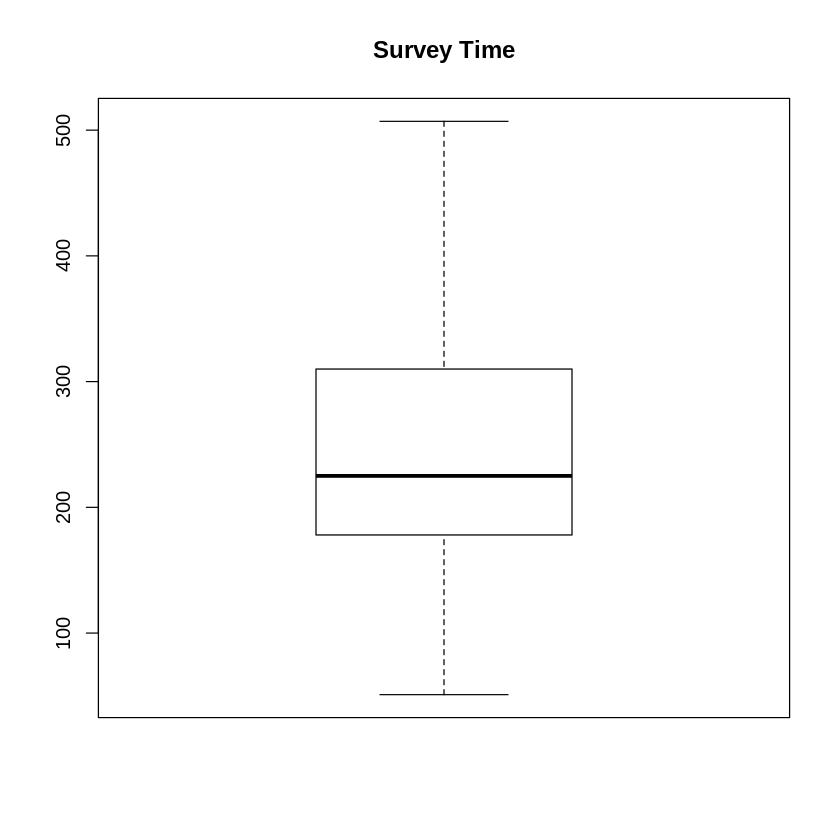

In [9]:
# Plot survey time box plot with excluded outliers
boxplot(survey_time, outline = FALSE, main="Survey Time")

### Question that took the longest and the least amount of time to complete?
Below is a graph of the mean submit times for each of the 12 questions.

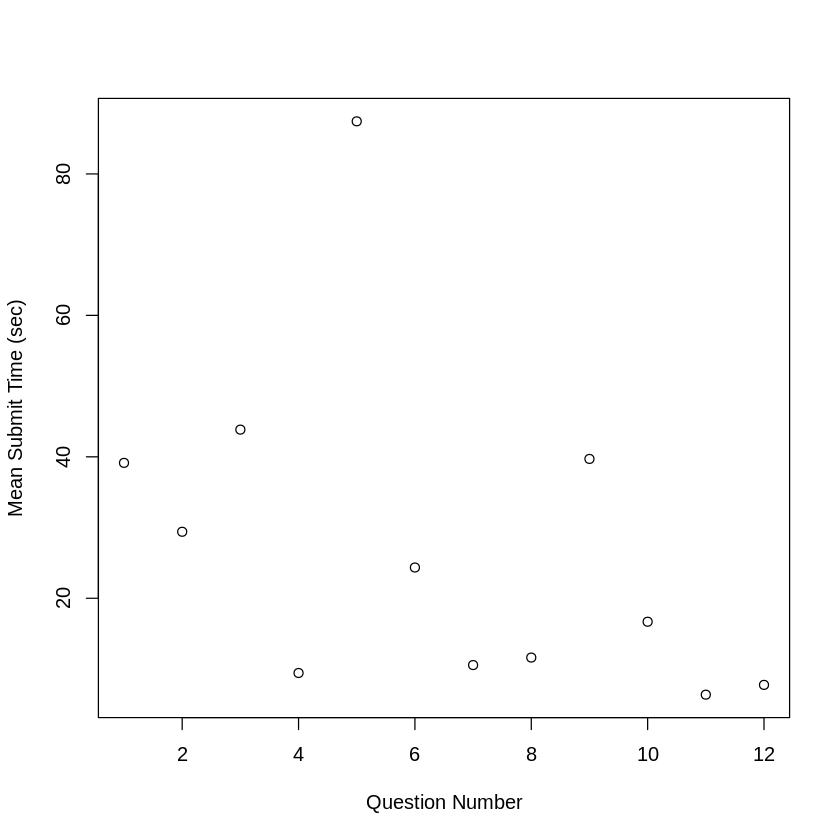

In [10]:
submit_cols <- grep("PG([1-9]).*Submit", names(data))
submit_means = apply(data[, submit_cols], 2, mean, na.rm = T)
plot(submit_means, xlab="Question Number", ylab="Mean Submit Time (sec)")

As you can see, question five took on average the longest to answer with a mean of about 1.5 minutes. Where as, question eleven on average took the shortest amount of time with a mean of about 6 seconds. These measures make sense with respect to the data because question 5 involved time-consuming ranking of 13 different factors for choosing a package for their project and question eleven only had 4 options total to choose from and asked a common question about gender.

### Top-ranked criteria?
For question five, the order of the criteria was recorded. Below is a graph showing the mean rankings for each of the 13 criteria outlined above in the introduction. 

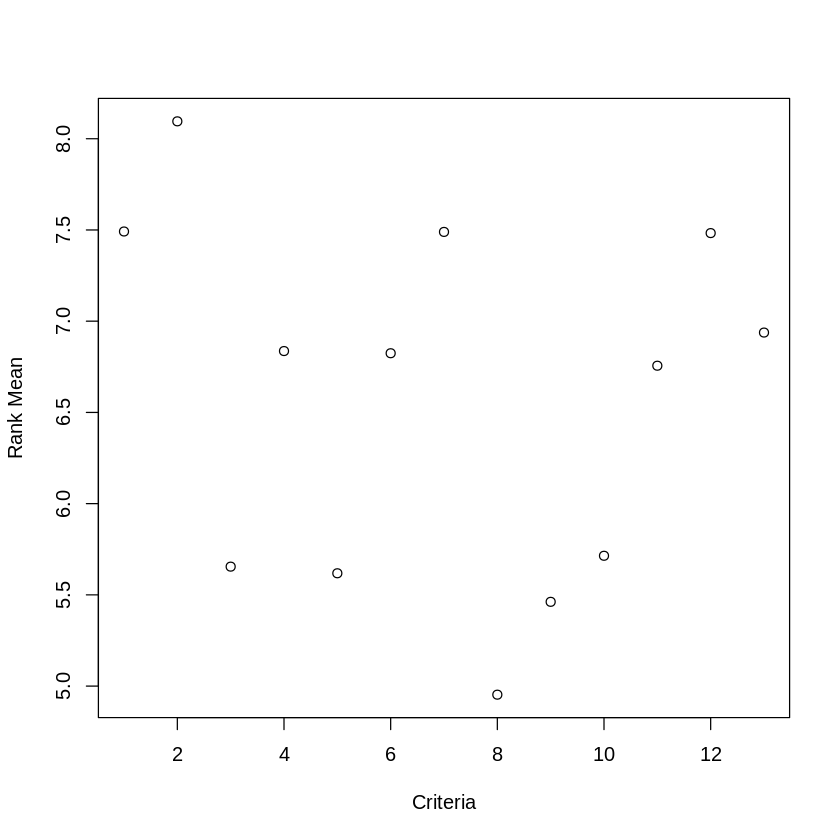

In [11]:
order_cols <- grep("PG5_.*Order", names(data))
order_mean = apply(data[, order_cols], 2, mean, na.rm = T)
plot(order_mean, xlab="Criteria", ylab="Rank Mean")

Based on the above scatter plot, criteria two was ranked the most often and the highest. Criteria two was backlog and number of unresolved issues. This measure is reasonable because a package with lots of unresolved issues or backlog would most likely not be picked as compared to a package with very few unresolved issues or backlog.

### Demographic distribution by age?
The ages of the surveyors where also recorded. Below is a histogram showing the distribution of the ages for this data set. Most of the surveyors were between 25-34 years of age. The35-44 years of age category was the second most.

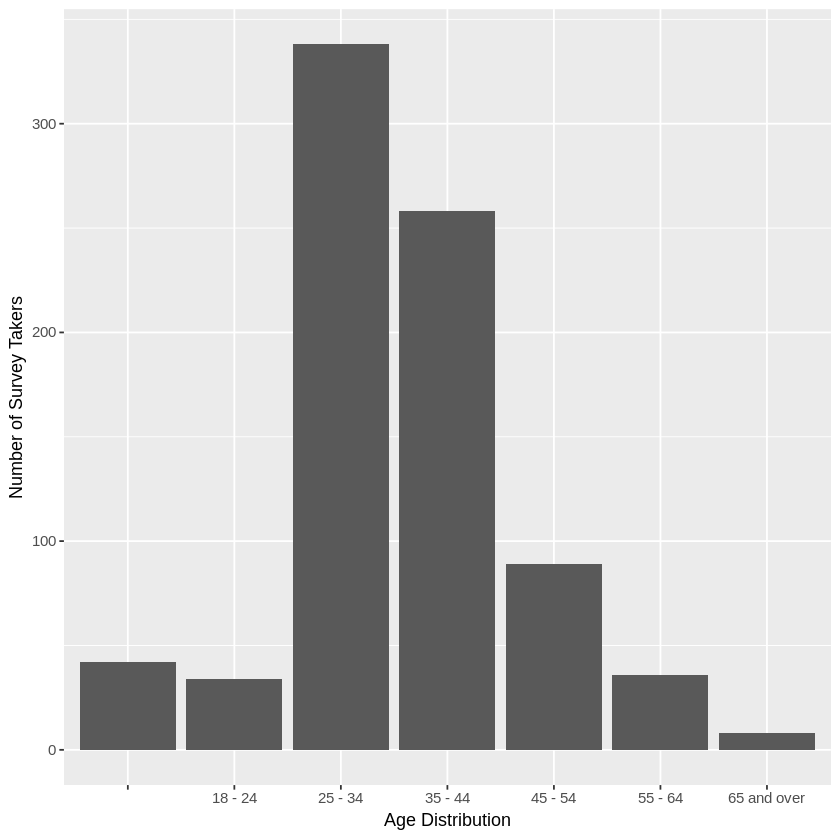

In [12]:
ggplot(data.frame(filtered_data[,81]), aes(x=filtered_data[,81])) + geom_bar() + xlab("Age Distribution") + ylab("Number of Survey Takers")


## Second Cleaning Step to Prep Data for Model
In order to look at just our response variable, we will need to remove all variables relating to the other response variables from page 5.

In [13]:
# Get and print a list of column headers
data_header_list <- colnames(filtered_data)
print(data_header_list)

 [1] "Device"        "Completed"     "Start"         "End"          
 [5] "PG0Dis"        "PG0Shown"      "PG0Submit"     "PG1PsnUse"    
 [9] "PG1WdAuth"     "PG1Trn"        "PG1Other"      "PG1Submit"    
[13] "PG2Resp"       "PG2Submit"     "PG2Resp.1"     "PG3Submit"    
[17] "PG4Dtr0_6"     "PG4Psv7_8"     "PG4Prm9_10"    "PG4AllResp"   
[21] "PG4Submit"     "PG5_1RRPQ"     "PG5_1Order"    "PG5_1Time"    
[25] "PG5_2BNUI"     "PG5_2Order"    "PG5_2Time"     "PG5_3HDS"     
[29] "PG5_3Order"    "PG5_3Time"     "PG5_4VGP"      "PG5_4Order"   
[33] "PG5_4Time"     "PG5_5PHR"      "PG5_5Order"    "PG5_5Time"    
[37] "PG5_6SSYOP"    "PG5_6Order"    "PG5_6Time"     "PG5_7NDYP"    
[41] "PG5_7Order"    "PG5_7Time"     "PG5_8CP"       "PG5_8Order"   
[45] "PG5_8Time"     "PG5_9FRP"      "PG5_9Order"    "PG5_9Time"    
[49] "PG5_10RPA"     "PG5_10Order"   "PG5_10Time"    "PG5_11NSG"    
[53] "PG5_11Order"   "PG5_11Time"    "PG5_12NWG"     "PG5_12Order"  
[57] "PG5_12Time"    "PG5_13NFG"  

In [14]:
# REMOVE BY INDEX all response variables from page 5 that were not assigned to me
data_trunc <- filtered_data[ , -c(22:48,52:61)]

# Confirm correct columns were extracted
data_trunc_header_list <- colnames(data_trunc)
print(data_trunc_header_list)

# Save dimensions of truncated data frame into variables and print the size of the data frame.
# Note: dim(object_name) returns a vector described as (num of rows, num of columns)
num_of_rows = dim(data_trunc)[1]
num_of_columns = dim(data_trunc)[2]
print(paste("There are", num_of_rows, "rows and", num_of_columns,"columns."))

 [1] "Device"        "Completed"     "Start"         "End"          
 [5] "PG0Dis"        "PG0Shown"      "PG0Submit"     "PG1PsnUse"    
 [9] "PG1WdAuth"     "PG1Trn"        "PG1Other"      "PG1Submit"    
[13] "PG2Resp"       "PG2Submit"     "PG2Resp.1"     "PG3Submit"    
[17] "PG4Dtr0_6"     "PG4Psv7_8"     "PG4Prm9_10"    "PG4AllResp"   
[21] "PG4Submit"     "PG5_10RPA"     "PG5_10Order"   "PG5_10Time"   
[25] "PG6Resp"       "PG6Submit"     "PG7R"          "PG7C.C.."     
[29] "PG7Java"       "PG7Python"     "PG7Javascript" "PG7Go"        
[33] "PG7C."         "PG7Other"      "PG7Submit"     "PG8Resp"      
[37] "PG8Submit"     "PG9Resp"       "PG9Submit"     "PG10Resp"     
[41] "PG10Submit"    "PG11Resp"      "PG11Submit"    "PG12Resp"     
[45] "PG12Submit"   
[1] "There are 805 rows and 45 columns."


In [15]:
# Uncomment to view data frame summary
# summary(data_trunc)

In [16]:
# Uncomment to view data frame structure
# str(data_trunc)

In [17]:
data_trunc <- replace(data_trunc, is.na(data_trunc), 0)

Warning message:
"Ignoring unknown parameters: binwidth, bins, pad"

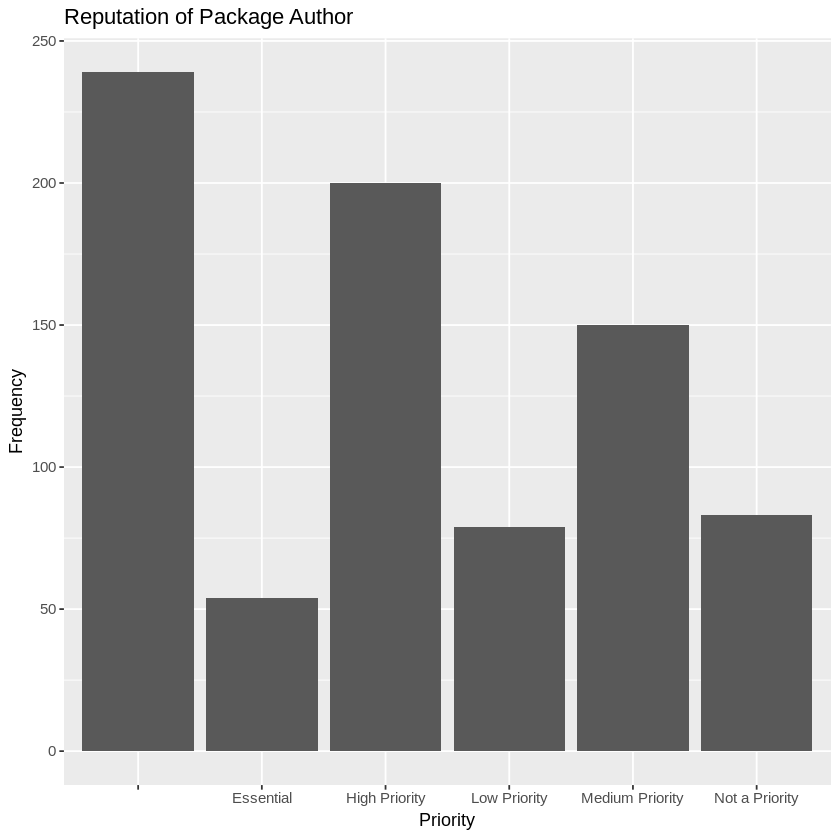

In [18]:
# Construct a histogram of the weights for my repsonse variable
ggplot(data = data_trunc, mapping = aes(x = PG5_10RPA)) +
    geom_histogram(stat="count") +
    ggtitle("Reputation of Package Author") +
    xlab("Priority") +
    ylab("Frequency")

In [19]:
# Initialize variables as emtpy vectors
numeric_fields = c()
non_numeric_fields = c()

# First check if fields are numeric or non-numeric
for (i in 1:num_of_columns){
    if (is.numeric(data_trunc[,i])){
        numeric_fields = c(numeric_fields, i)
        #print(numeric_fields)
    } else {
        non_numeric_fields = c(non_numeric_fields, i)
        #print(non_numeric_fields)
    }
}
# Run correlation analysis on numeric fields only
correlations <- cor(data_trunc[,numeric_fields],method="spearman",use="pairwise.complete.obs")

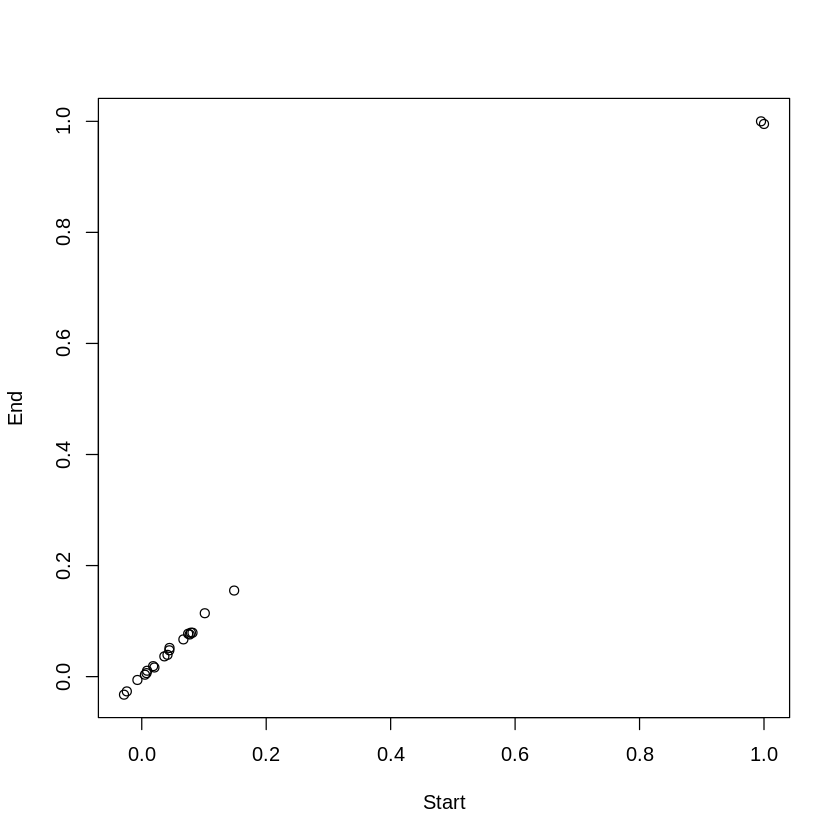

In [20]:
# Uncomment to plot correlations
plot(correlations)

In [33]:
res <- c();
vnam <- names(data_trunc[,numeric_fields]);
for (i in 2:dim(data_trunc[,numeric_fields])[2]){
  fmla <- as.formula(paste(vnam[i],paste(vnam[-c(1,i)],collapse="+"),sep="~"));
  res <- rbind(res,c(i,round(summary(lm(fmla,data=data_trunc[,numeric_fields]))$r.squared,2)));
}
row.names(res) <- vnam[res[,1]];
res[order(-res[,2]),];

Warning message in summary.lm(lm(fmla, data = data_trunc[, numeric_fields])):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(lm(fmla, data = data_trunc[, numeric_fields])):
"essentially perfect fit: summary may be unreliable"

PG4Dtr0_6,9,1.00
PG4Psv7_8,10,1.00
PG4Prm9_10,11,1.00
PG4AllResp,12,1.00
PG0Shown,4,0.44
PG0Dis,3,0.43
PG8Submit,17,0.27
PG9Submit,18,0.26
PG4Submit,13,0.07
PG2Submit,7,0.05
End,2,0.04


## Fitting of the statistical model

Create a train and test set for model 70/30 ratio.

In [22]:
trainSize <- round(nrow(data_trunc) * 0.7)
testSize <- nrow(data_trunc) - trainSize
print(trainSize)
print(testSize)

[1] 564
[1] 241


In [23]:
set.seed(123)
training_indices <- sample(seq_len(nrow(data_trunc)), size=trainSize)
trainSet <- data_trunc[training_indices, ]
testSet <- data_trunc[-training_indices, ]

In [24]:
data_trunc$PG5_10RPA<- as.factor(as.character(data_trunc$PG5_10RPA))
model <- rpart(PG5_10RPA ~ ., data = trainSet, method = "anova")
#model2 <- rpart(PG5_10RPA ~ ., data = trainSet, method = "class")

In [25]:
printcp(model)


Regression tree:
rpart(formula = PG5_10RPA ~ ., data = trainSet, method = "anova")

Variables actually used in tree construction:
[1] PG5_10Order PG5_10Time 

Root node error: 1658/564 = 3

n= 564 

  CP nsplit rel error xerror xstd
1  1      0         1      1    0
2  0      1         0      1    0
3  0      2         0      0    0
4  0      3         0      1    0
5  0      4         0      1    0
6  0      5         0      0    0


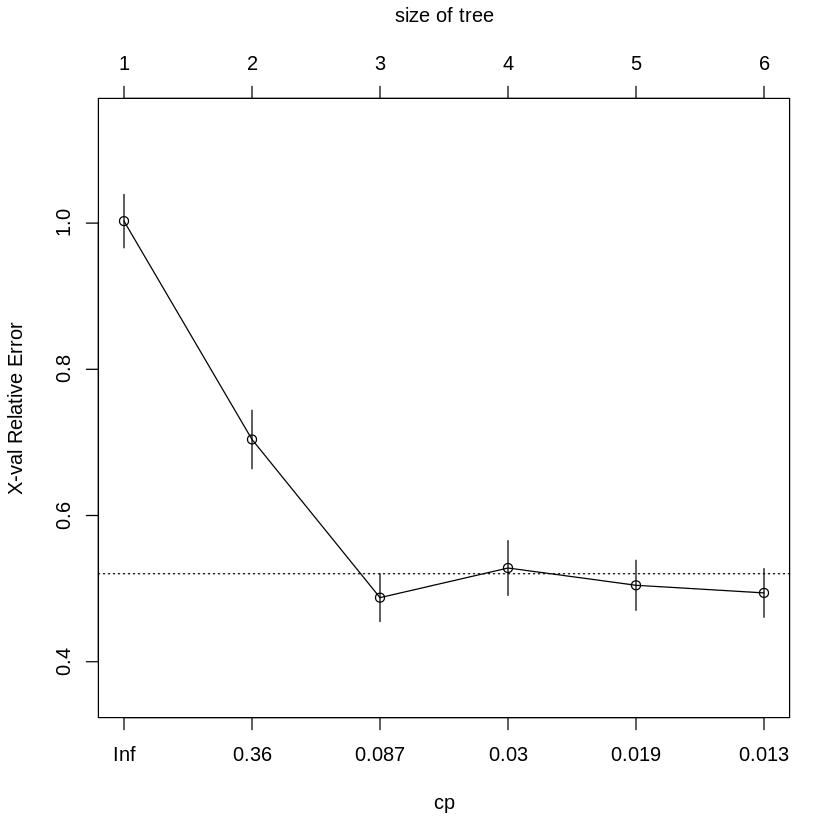

In [26]:
plotcp(model)

In [27]:
summary(model)

Call:
rpart(formula = PG5_10RPA ~ ., data = trainSet, method = "anova")
  n= 564 

     CP nsplit rel error xerror  xstd
1 0.740      0    1.0000   1.00 0.036
2 0.172      1    0.2604   0.70 0.040
3 0.044      2    0.0886   0.49 0.033
4 0.020      3    0.0450   0.53 0.037
5 0.017      4    0.0247   0.50 0.034
6 0.010      5    0.0072   0.49 0.033

Variable importance
 PG5_10Time PG5_10Order     PG8Resp   PG2Resp.1  PG4AllResp  PG4Prm9_10 
         42          22          14          11           2           2 
       PG7R    PG1Other  PG10Submit 
          2           2           2 

Node number 1: 564 observations,    complexity param=0.74
  mean=3.1, MSE=2.9 
  left son=2 (351 obs) right son=3 (213 obs)
  Primary splits:
      PG5_10Time  splits as  L-R-L--RRRL-R--RRL--RLLRR-RLRR-R-RRR-RLR-RRR-RRRLLLR--RLRRL---LLLR-RLLLRLRRLL-LL-LR-RL-LL-R---LLRR-LRRRRLLL---LL--RLLR---LLR--RR--R--RRRRRLLRRL-LLLR-RLRLR-LLR-L-L-RRLRR-L-R-LL--L-RLLRL-LLLLLR--LL---LR--L-R-LRLLL-L--LLRLL-R-R-LLL-LRRRRLRRR


Regression tree:
rpart(formula = PG5_10RPA ~ ., data = trainSet, method = "anova")

Variables actually used in tree construction:
[1] PG5_10Order PG5_10Time 

Root node error: 1658/564 = 3

n= 564 

  CP nsplit rel error xerror xstd
1  1      0         1      1    0
2  0      1         0      1    0
3  0      2         0      0    0
4  0      3         0      1    0
5  0      4         0      1    0
6  0      5         0      0    0


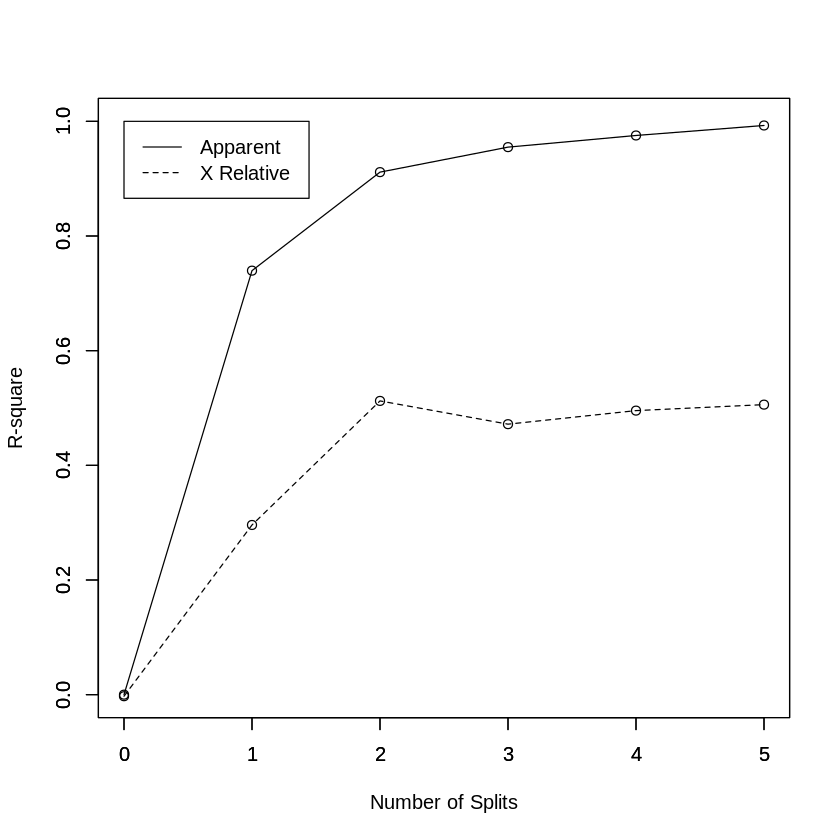

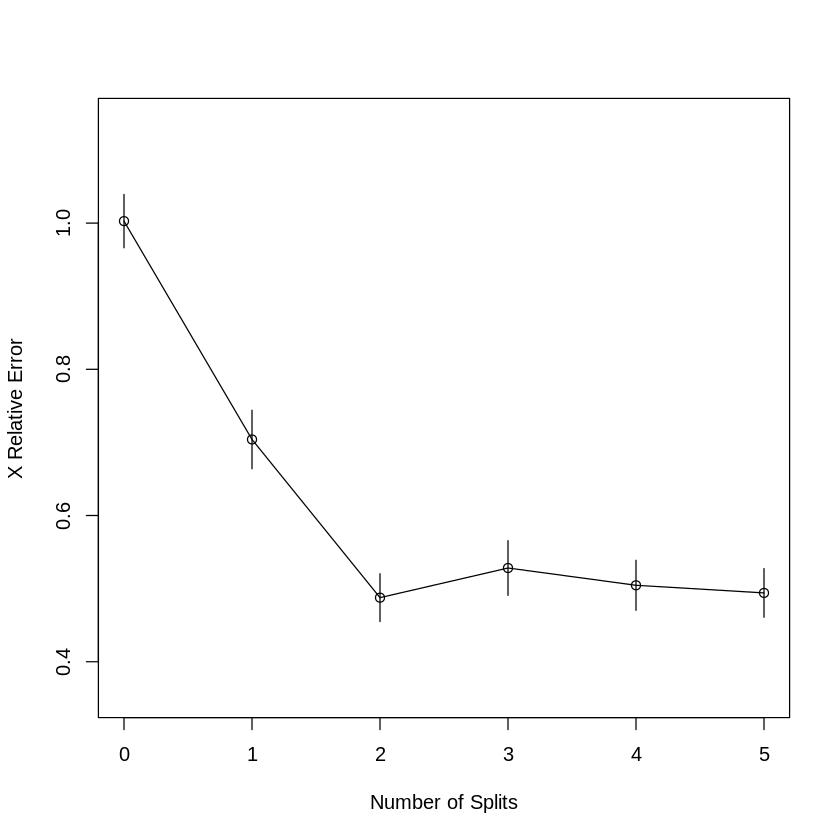

In [31]:
rsq.rpart(model)

In [29]:
predictionResult <- predict(model, testSet)

In [34]:
predicted <- 1/(1+exp(-predict(model,testSet)));
tapply(predicted, testSet$PG5_10RPA, mean)

ERROR while rich displaying an object: Error in dn[[2L]]: subscript out of bounds

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_markdown.numeric(obj)
9. repr_vector_generic(html_escape_names(obj), "%s. %s\n", "%s\n:   %s", 
 .     "**%s:** %s", "%s\n\n", item_uses_numbers = TRUE, escape_fun = html_escape)
10. html_escape_names(obj)
11. .escape_names(obj, "html")
12. colnames(obj)
ERROR while rich displaying an object: 

Essential   High Priority    Low Priority Medium Priority 
           0.73            0.98            0.98            0.99            0.99 
 Not a Priority 
           0.99